In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("dataset/prices-split-adjusted.csv")
df = pd.DataFrame(data)
df.drop(columns=['date'], inplace=True)
df.head()

,symbol,open,close,low,high,volume
0,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


#### Data Information

In [3]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [4]:
# showing column wise %ge of NaN values they contains 

for i in df.columns:
  print(i,"\t-\t", df[i].isna().mean()*100)

symbol 	-	 0.0
open 	-	 0.0
close 	-	 0.0
low 	-	 0.0
high 	-	 0.0
volume 	-	 0.0


Since there is no null valus, we can move further

<Axes: >

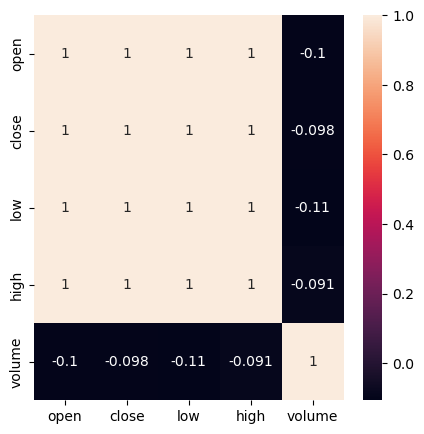

In [5]:
features = ['open', 'close', 'low', 'high', 'volume']

df = df[df['symbol']=='AAP'][features]   # Choosin stock values for any company 

cormap = df.corr()
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cormap, annot = True)

In [6]:
def get_corelated_col(cor_dat, threshold): 
  # Cor_data to be column along which corelation to be measured 
  #Threshold be the value above which of corelation to considered
  feature=[]
  value=[]

  for i ,index in enumerate(cor_dat.index):
    if abs(cor_dat[index]) > threshold:
      feature.append(index)
      value.append(cor_dat[index])

  df = pd.DataFrame(data = value, index = feature, columns=['corr value'])
  return df

In [7]:
top_corelated_values = get_corelated_col(cormap['close'], 0.60)
top_corelated_values

,corr value
open,0.999382
close,1.000000
low,0.999615
high,0.999737


Looks like all colums except volume are **highly co-related**. Using them for predictions.

In [8]:
df = df[top_corelated_values.index]
df.head()

,open,close,low,high
253,40.700001,40.380001,40.360001,41.040001
720,40.299999,40.139999,39.720001,40.310001
1188,40.049999,40.490002,40.049999,40.779999
1656,39.549999,40.480000,39.549999,40.540001
2124,40.250000,40.639999,40.110001,40.820000


In [9]:
df.shape

(1762, 4)

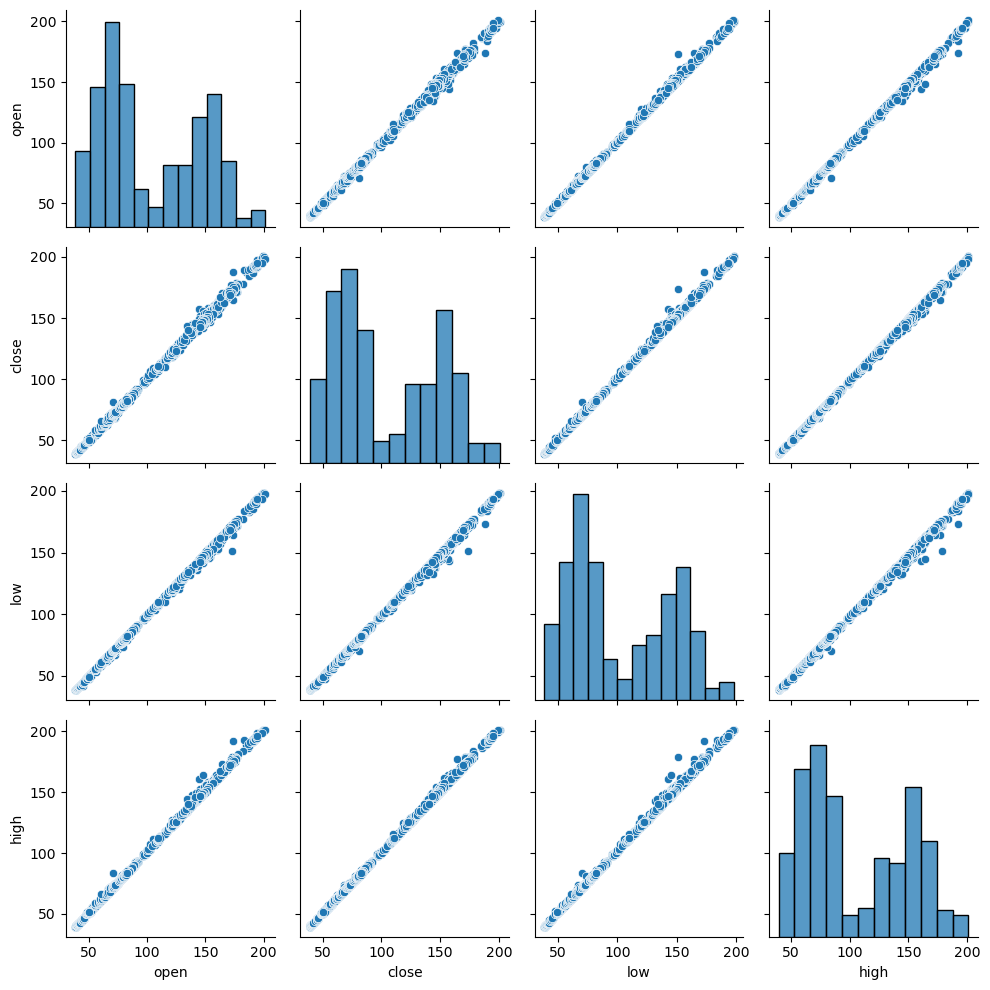

In [10]:
sns.pairplot(df)
plt.tight_layout()

Since other parameters have linear relationship with close, we are using some linear models fore prediction

In [11]:
X = df.drop(['close'], axis=1)
y = df['close']

Since range of data in different columns veries significantly we need to scale the independent variable i.e. X. For this we will use Min-Max Scaling.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,open,low,high
0,0.012001,0.012392,0.010256
1,0.009539,0.008387,0.005746
2,0.008000,0.010452,0.008649
3,0.004923,0.007323,0.007167
4,0.009231,0.010827,0.008897


#### Prediction Model

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

##### Linear Regression

In [14]:
from sklearn.linear_model import LinearRegression

model_1 = LinearRegression()
model_1.fit(X_train, y_train)

# prediction
y_pred_1 = model_1.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1})
pred_df.head()

,Actual,Predicted
675111,173.660004,173.682489
675608,171.919998,172.593759
676105,172.000000,171.182789
676602,187.789993,187.980305
677099,187.029999,188.440838


In [15]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.9931342019332019


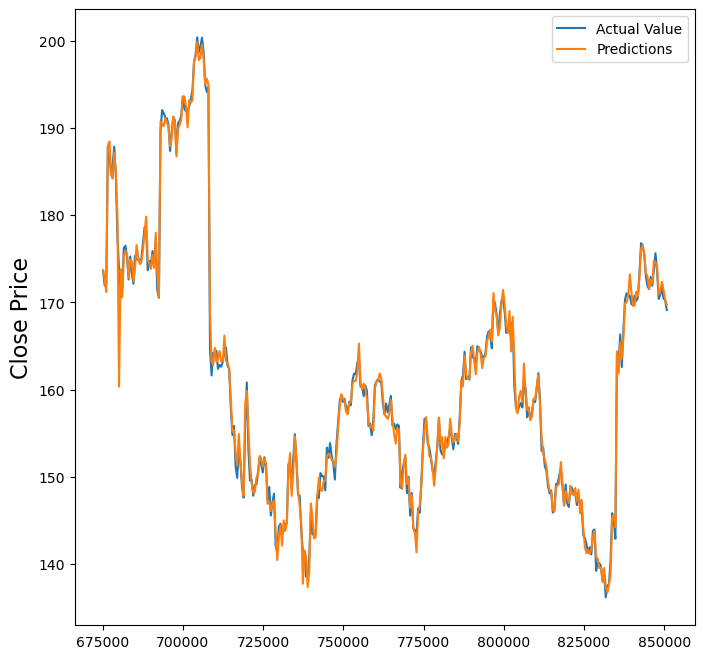

In [16]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

##### ANN

In [17]:
from keras.models import Sequential
from keras.layers import Dense

def regressor(inp_dim):
    
    model = Sequential()
    
    model.add(Dense(20, input_dim=inp_dim, kernel_initializer='normal', activation='relu'))
    model.add(Dense(25, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [18]:
model_2 = regressor(inp_dim=3)
model_2.fit(X_train, y_train, epochs=70, validation_split=0.2)

# Prediction
y_pred_2 = model_2.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2.flatten()})
pred_df.head()

/Users/killua/miniforge3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-15 19:38:14.618966: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-15 19:38:14.618987: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-15 19:38:14.618992: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-15 19:38:14.619032: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-15 19:38:14.619043: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_facto

Epoch 1/70


2024-12-15 19:38:15.745875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 6150.7153 - val_loss: 22085.1152
Epoch 2/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6118.4502 - val_loss: 22030.4688
Epoch 3/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5963.6963 - val_loss: 21847.4336
Epoch 4/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5933.5962 - val_loss: 21357.7266
Epoch 5/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5686.1318 - val_loss: 20281.7246
Epoch 6/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5405.7534 - val_loss: 18317.1504
Epoch 7/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4610.9355 - val_loss: 15263.9561
Epoch 8/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3604.4785 - val_loss: 11219.8721
Epoch 9/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2466.8450 - val_loss: 6839.1685
Epoch 10/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1260.4810 - val_loss: 3227.7805
Epoch 11/70
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 457.7780 - val_loss: 1219.2048
E

,Actual,Predicted
675111,173.660004,173.460968
675608,171.919998,171.793442
676105,172.000000,170.022751
676602,187.789993,178.778229
677099,187.029999,187.421524


In [19]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.9849965060473467


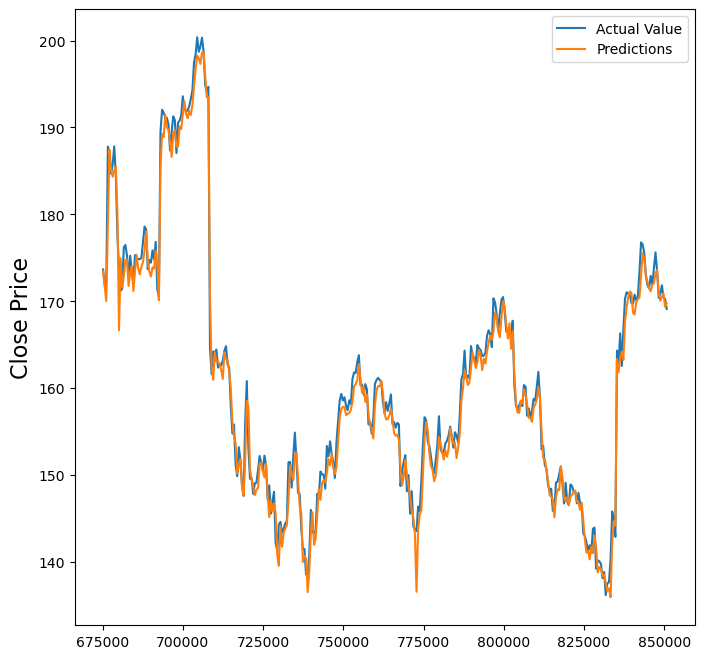

In [20]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

##### CNN

In [21]:
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

In [22]:
from keras import Sequential
from keras.layers import Flatten, Dense, Conv1D

def reg():
    
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=(3,), padding='same', activation='relu', input_shape = (X_train.shape[1],1)))
    model.add(Conv1D(64, kernel_size=(3,), padding='same', activation='relu'))
    model.add(Conv1D(128, kernel_size=(5,), padding='same', activation='relu'))
    
    model.add(Flatten())
    
    model.add(Dense(50, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(units = 1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [23]:
model_3 = reg()
model_3.fit(X_train, y_train, epochs=100, validation_split=0.2)

# Prediction
y_pred_3 = model_3.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

/Users/killua/miniforge3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5947.3774 - val_loss: 8917.4756
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 726.6918 - val_loss: 74.6590
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 28.8497 - val_loss: 42.5304
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1336 - val_loss: 22.1953
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.0484 - val_loss: 5.7387
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1.0191 - val_loss: 2.8120
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.5984 - val_loss: 2.2035
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5460 - val_loss: 1.7405
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4329 - val_loss: 1.7480
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4464 - val_loss: 1.7401
Epoch 11/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4543 - val_loss: 1.7434
Epoch 12/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 

,Actual,Predicted
675111,173.660004,174.329208
675608,171.919998,172.685974
676105,172.000000,170.851212
676602,187.789993,179.281815
677099,187.029999,188.505264


In [24]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.9880310212493834


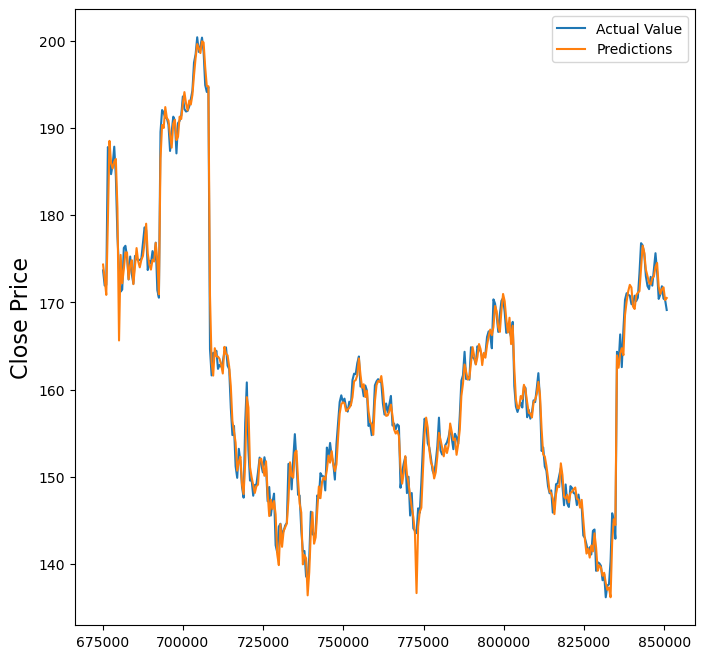

In [25]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

Comparision of Accuracies of different models

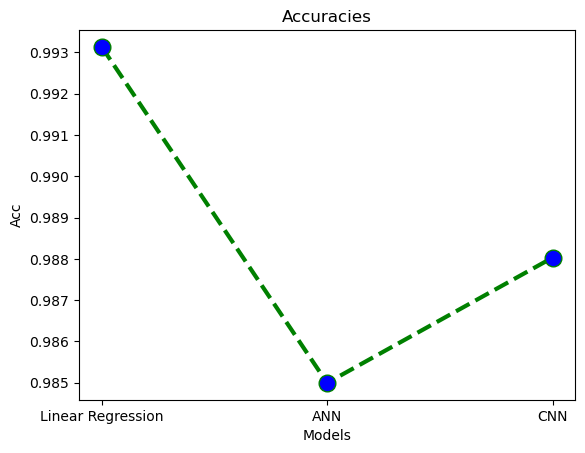

In [26]:
plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['Linear Regression', 'ANN', 'CNN'])
plt.show()

Now converting data in a time series data and applying some more models.

In [27]:
close = df.reset_index()['close']
close.head()

0    40.380001
1    40.139999
2    40.490002
3    40.480000
4    40.639999
Name: close, dtype: float64

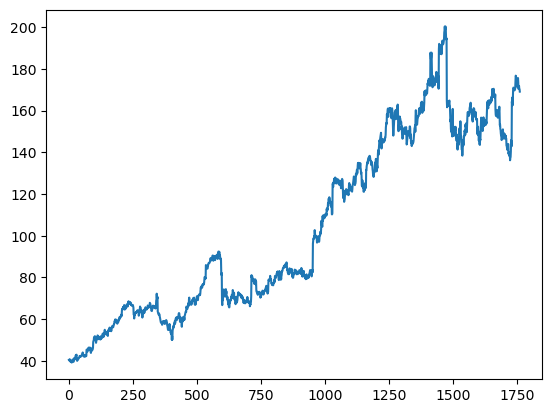

In [28]:
plt.plot(close)
plt.show()

In [29]:
time_step = 30
X, y = [], []

for i in range(len(close)-time_step-1):
    X.append(close[i:(i+time_step)])
    y.append(close[(i+time_step)])

X = np.array(X)
y = np.array(y)

In [30]:
X[:5], y[:5]

(array([[40.380001, 40.139999, 40.490002, 40.48    , 40.639999, 40.240002,
         39.540001, 40.09    , 39.560001, 39.310001, 39.5     , 39.16    ,
         39.23    , 39.740002, 40.5     , 40.549999, 40.59    , 39.77    ,
         39.450001, 40.490002, 41.189999, 41.189999, 40.93    , 40.720001,
         40.810001, 41.57    , 42.330002, 42.549999, 42.810001, 42.630001],
        [40.139999, 40.490002, 40.48    , 40.639999, 40.240002, 39.540001,
         40.09    , 39.560001, 39.310001, 39.5     , 39.16    , 39.23    ,
         39.740002, 40.5     , 40.549999, 40.59    , 39.77    , 39.450001,
         40.490002, 41.189999, 41.189999, 40.93    , 40.720001, 40.810001,
         41.57    , 42.330002, 42.549999, 42.810001, 42.630001, 42.880001],
        [40.490002, 40.48    , 40.639999, 40.240002, 39.540001, 40.09    ,
         39.560001, 39.310001, 39.5     , 39.16    , 39.23    , 39.740002,
         40.5     , 40.549999, 40.59    , 39.77    , 39.450001, 40.490002,
         41.189999, 41.

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.007567,0.006079,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,...,0.007420,0.007420,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399
1,0.006079,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,...,0.007420,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957
2,0.008250,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,...,0.005799,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935
3,0.008188,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,0.000434,...,0.004489,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935,0.000000
4,0.009180,0.006699,0.002357,0.005769,0.002481,0.000930,0.002109,0.000000,0.000434,0.003598,...,0.005051,0.009789,0.014528,0.015900,0.017521,0.016399,0.017957,0.000935,0.000000,0.001496


#### Prediction

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=False)

Acc = []

##### LSTM

In [33]:
X_train_ = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test_ = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [34]:
from tensorflow.keras.layers import LSTM

def Reg():
    model = Sequential()
    
    model.add(LSTM(70, return_sequences=True, input_shape=(30,1)))
    model.add(LSTM(70, return_sequences=True))
    model.add(LSTM(70))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    return model

In [35]:
model_1 = reg()
model_1.fit(X_train_, y_train, epochs=100, validation_split=0.2)

y_pred_1 = model_1.predict(X_test_)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_1.flatten()})
pred_df.head()

Epoch 1/100


/Users/killua/miniforge3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 5071.7412 - val_loss: 562.0244
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 186.3331 - val_loss: 188.8290
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 20.8312 - val_loss: 62.0966
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 17.0166 - val_loss: 36.1130
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14.9525 - val_loss: 39.0738
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 14.7483 - val_loss: 36.9069
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15.2967 - val_loss: 40.9564
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 13.7049 - val_loss: 37.1649
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 15.7039 - val_loss: 56.7997
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 14.2379 - val_loss: 33.5831
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 15.0081 - val_loss: 34.8700
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━

,Actual,Predicted
0,184.690002,187.680405
1,185.770004,187.446167
2,187.839996,188.359344
3,184.449997,190.234955
4,177.539993,189.236328


In [36]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_1)))
Acc.append(r2_score(y_test, y_pred_1))

Accuracy score of the predictions: 0.8993891360190371


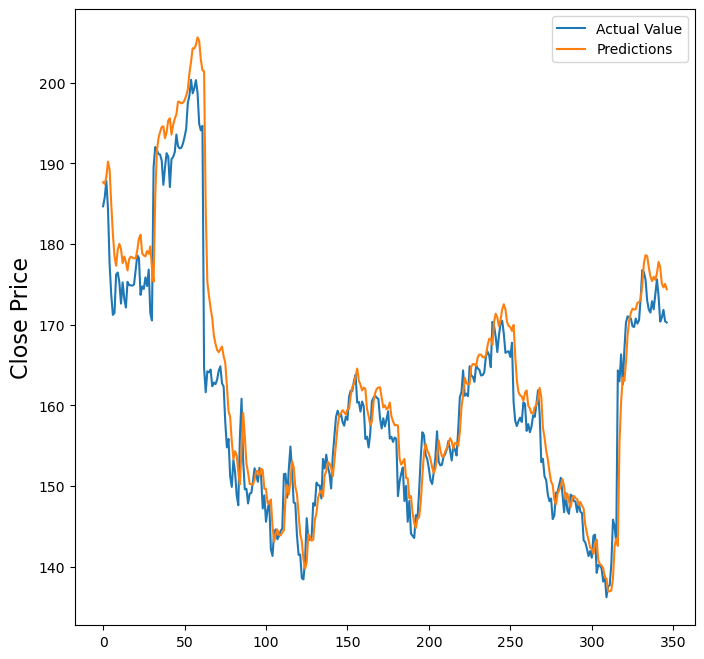

In [37]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

##### ANN

In [38]:
model_2 = regressor(inp_dim=30)
model_2.fit(X_train, y_train, epochs=100, validation_split=0.2)

y_pred_2 = model_2.predict(X_test)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_2.flatten()})
pred_df.head()

Epoch 1/100


/Users/killua/miniforge3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6122.7549 - val_loss: 22413.5684
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6360.2676 - val_loss: 22292.3359
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6027.9849 - val_loss: 21682.4727
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6052.2783 - val_loss: 19826.3184
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5514.5103 - val_loss: 15757.4805
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4263.0435 - val_loss: 9236.7891
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2774.8416 - val_loss: 2606.2200
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1170.3081 - val_loss: 40.3766
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 343.9719 - val_loss: 996.3843
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 204.4724 - val_loss: 1398.3994
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 204.0319 - val_loss: 1311.2852

,Actual,Predicted
0,184.690002,175.664948
1,185.770004,176.673874
2,187.839996,177.839249
3,184.449997,179.115814
4,177.539993,179.839920


In [39]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_2)))
Acc.append(r2_score(y_test, y_pred_2))

Accuracy score of the predictions: 0.6621463663423244


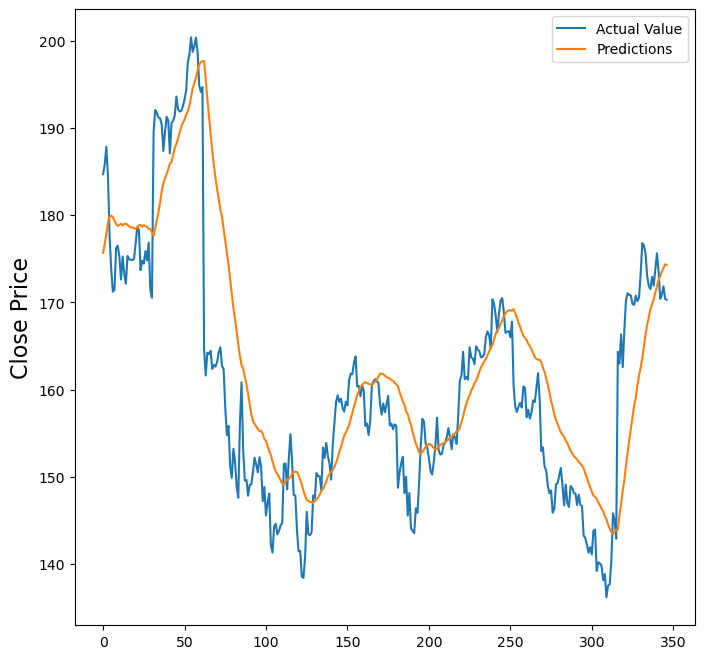

In [40]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

##### CNN

In [41]:
model_3 = reg()
model_3.fit(X_train_, y_train, epochs=100, validation_split=0.2)

y_pred_3 = model_3.predict(X_test_)
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_3.flatten()})
pred_df.head()

Epoch 1/100


/Users/killua/miniforge3/envs/stock_pred/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 4608.9570 - val_loss: 604.8094
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 167.0111 - val_loss: 256.5587
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 26.8514 - val_loss: 38.4593
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 17.9685 - val_loss: 33.8282
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 14.8122 - val_loss: 35.8243
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15.3726 - val_loss: 33.7877
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 15.8816 - val_loss: 30.9978
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 15.9714 - val_loss: 31.9682
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 16.0944 - val_loss: 30.7949
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 15.1080 - val_loss: 30.5690
Epoch 11/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 16.1181 - val_loss: 29.8280
Epoch 12/100
35/35 ━━━━━━━━━━━━━━━━━━

,Actual,Predicted
0,184.690002,183.429535
1,185.770004,184.471130
2,187.839996,184.768433
3,184.449997,185.901947
4,177.539993,185.121674


In [42]:
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, y_pred_3)))
Acc.append(r2_score(y_test, y_pred_3))

Accuracy score of the predictions: 0.9225746601198083


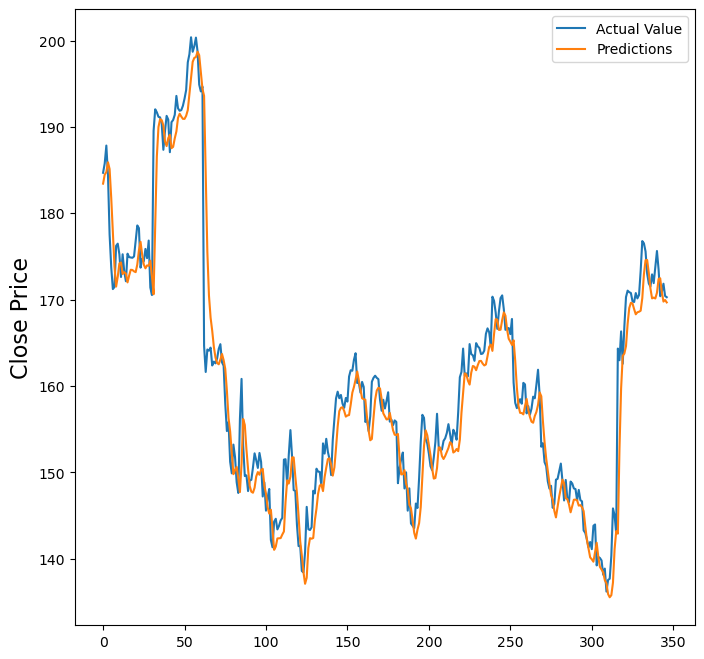

In [43]:
plt.figure(figsize=(8,8))
plt.ylabel('Close Price', fontsize=16)
plt.plot(pred_df)
plt.legend(['Actual Value', 'Predictions'])
plt.show()

Comparision of Accuracies of different models

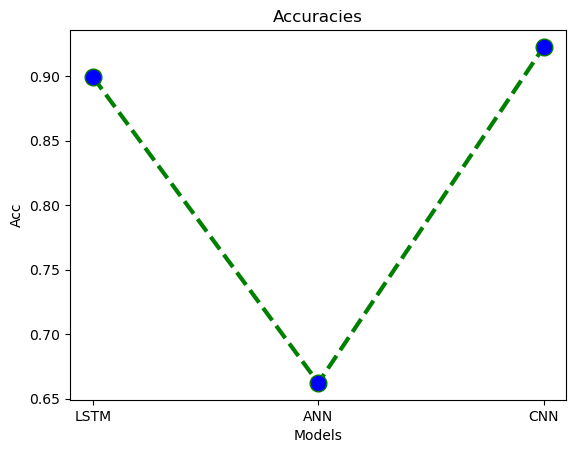

In [44]:
plt.plot(range(3), Acc, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("Accuracies")
plt.xticks(range(3), ['LSTM', 'ANN', 'CNN'])
plt.show()